# 5-2. 학습 관련 기술들(Techniques) 

- 책 Deep Learning from Scratch 6장 참조할 것

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from collections import OrderedDict
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### MultiLayerNetExtend 정의

In [2]:
# 아래 MultiLayerNetExtend에서 쓰일 함수 정의
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        x[idx] = tmp_val - h 
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [3]:
# Optimizer 정의
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)  
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

# NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
class Nesterov:
    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)  
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [4]:
# 오차역전파법을 위한 계층 정의
# 아래 MultiLayerNetExtend에서 쓰일 클래스 정의
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)
        return dx

# 배치 정규화 계층
class BatchNormalization:
    """http://arxiv.org/abs/1502.03167"""
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# 드롭아웃 계층
class Dropout:
    """http://arxiv.org/abs/1207.0580"""
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

In [5]:
# 배치 정규화, 가중치 감소, 드롭아웃 등의 기능을 추가하여 MultiLayerNet을 확장한 것
# 가중치 감소에 다양한 norm을 적용할 수 있도록 약간 수정하였다.
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', norm="L2", weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.norm = norm
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            # 배치 정규화 계층의 생성
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)],
                                                                         self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            # 드롭아웃을 이용할 때
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            if self.norm == "L2":
                weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
            elif self.norm == "L1":
                weight_decay += self.weight_decay_lambda * np.sum(np.abs(W)) # L1 Norm
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)
        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        loss_W = lambda W: self.loss(X, T, train_flg=True)
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            # 배치 정규화를 고려한 부분
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            weight_decay = 0
            if self.norm == "L2":
                weight_decay = self.weight_decay_lambda * self.params['W' + str(idx)]
            elif self.norm == "L1":
                weight_decay = self.weight_decay_lambda * np.sign(self.params['W' + str(idx)])
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + weight_decay
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            # 배치 정규화를 고려한 부분
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta
        return grads

### 배치 정규화(Batch Normalization)

#### 활성화값의 분포를 강제적으로 퍼뜨리는 방법으로 다음의 장점을 갖는다.
- 학습 속도 개선
- 초깃값에 크게 의존하지 않는다.
- 오버피팅(overfitting)을 억제한다.

#### Frederik Kratzert의 블로그 참조
- http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

In [6]:
# MNIST 데이터 로딩
# 디폴트 설정으로 flatten=True, one_hot_label=False이다.
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

# 하이퍼파라미터 설정
max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

============== 1/16 ==============
epoch:10 | 0.097 - 0.236
epoch:20 | 0.097 - 0.38
============== 2/16 ==============
epoch:10 | 0.097 - 0.279
epoch:20 | 0.097 - 0.472
============== 3/16 ==============
epoch:10 | 0.86 - 0.394
epoch:20 | 0.969 - 0.658
============== 4/16 ==============
epoch:10 | 0.712 - 0.55
epoch:20 | 0.848 - 0.744
============== 5/16 ==============
epoch:10 | 0.172 - 0.76
epoch:20 | 0.258 - 0.907
============== 6/16 ==============
epoch:10 | 0.116 - 0.822
epoch:20 | 0.145 - 0.945
============== 7/16 ==============
epoch:10 | 0.117 - 0.906
epoch:20 | 0.117 - 0.982
============== 8/16 ==============
epoch:10 | 0.116 - 0.972
epoch:20 | 0.117 - 0.999
============== 9/16 ==============
epoch:10 | 0.116 - 0.973
epoch:20 | 0.116 - 0.999
============== 10/16 ==============
epoch:10 | 0.117 - 0.884
epoch:20 | 0.117 - 0.999
============== 11/16 ==============
epoch:10 | 0.117 - 0.885
epoch:20 | 0.116 - 0.993
============== 12/16 ==============
epoch:10 | 0.117 - 0.872
epoch:

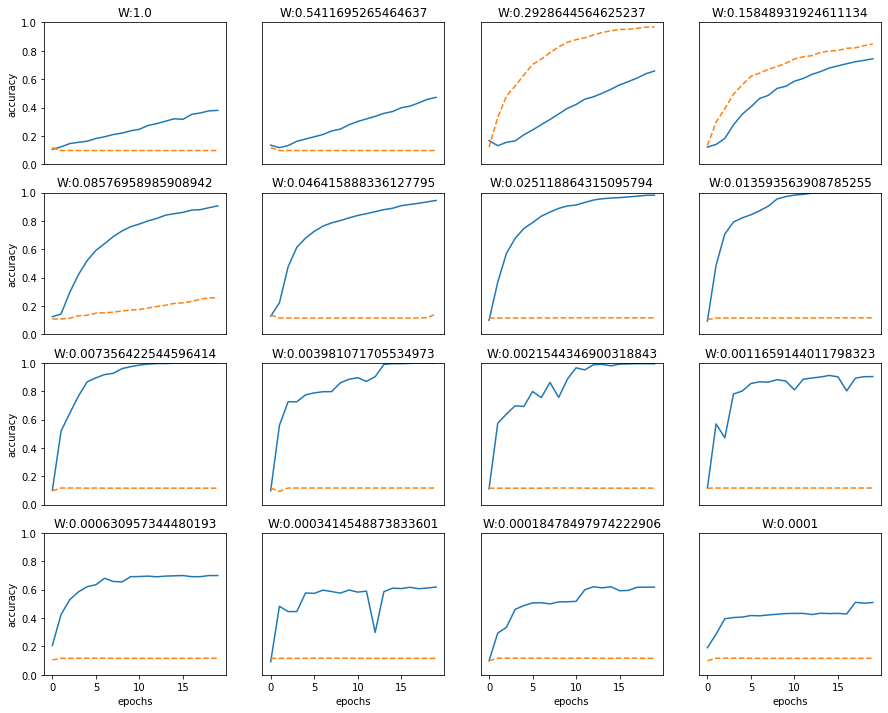

In [7]:
# 훈련 실행 함수
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            epoch_cnt += 1
            if epoch_cnt % 10 == 0:
                print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
           
            if epoch_cnt >= max_epochs: break
                
    return train_acc_list, bn_train_acc_list

# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)  # log(x) 값이 0에서 -4사이가 되는 x를 logspace상의 등간격으로 16개 뽑아낸다.
x = np.arange(max_epochs)
plt.figure(figsize=(15,12))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.show()

- 배치정규화를 적용했을 때(blue line)가 그렇지 않은 경우(orange line)보다 학습결과가 대부분 더 좋으며, 학습속도도 빠르다.
- 배치정규화를 적용하지 않았을 때는 가중치의 표준편차에 따라 학습이 아예 안되는 경우가 많지만, 배치정규화를 적용하면 가중치의 표준편차에 덜 예민하다.

### 오버피팅(Overfitting)

#### MNIST로 오버피팅 재현하기
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음
- 위 두가지 경우에 대해 오버피팅이 발생한다.

In [8]:
# MNIST 데이터 불러오기
# 디폴트 설정으로 flatten=True, one_hot_label=False이다.
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

#### 가중치 감소로 오버피팅 해결하기 
- 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많다.
- 따라서 큰 가중치에 대해서 그에 상응하는 큰 패널티를 부과하므로써 오버피팅을 막는다.

epoch:0, train acc:0.09666666666666666, test acc:0.0955
epoch:100, train acc:0.9833333333333333, test acc:0.7287
epoch:200, train acc:1.0, test acc:0.7469


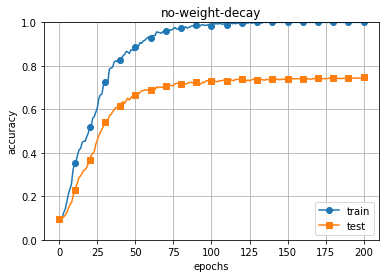

epoch:0, train acc:0.1, test acc:0.0979
epoch:100, train acc:0.8366666666666667, test acc:0.654
epoch:200, train acc:0.9166666666666666, test acc:0.6897


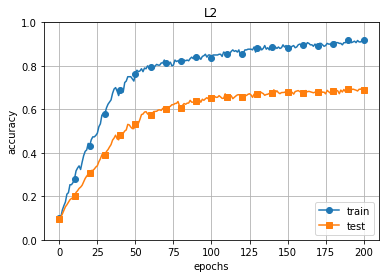

epoch:0, train acc:0.11, test acc:0.0992
epoch:100, train acc:0.8466666666666667, test acc:0.6671
epoch:200, train acc:0.8766666666666667, test acc:0.6908


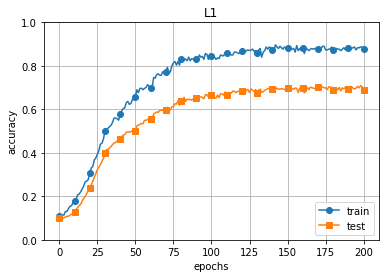

In [9]:
# 하이퍼파라미터 설정
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

# weight decay（가중치 감쇠） 설정
# 정규화의 세기값 0과 0.1의 경우 비교
for norm, weight_decay_lambda in [["no-weight-decay", 0], ["L2", 0.1], ["L1", 0.01]]:

    # 7층 신경망의 생성
    # activation과 weight_init_std는 default로 relu이다.
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            norm=norm, weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            if i % 100 == 0:
                print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
            epoch_cnt += 1
            if epoch_cnt >= max_epochs: break

    # 그래프 그리기==========
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(max_epochs)
    plt.title(norm)
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

- 가중치 감소를 이용하면, train 데이터에 대한 정확도와 test 데이터에 대한 정확도의 차이가 줄어드는 것을 확인할 수 있다.
- 즉,오버피팅이 억제되었다.

#### 드롭아웃(drop-out)으로 오버피팅 해결하기 
- 앙상블 학습(ensemble learning) : 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식
- 드롭아웃이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석할 수 있다.
- 즉, 드롭아웃은 하나의 신경망으로 앙상블 학습 효과를 구현했다고 볼 수 있다.

In [10]:
# 이번에는 편의를 위해 신경망 훈련을 대신 해주는 클래스를 정의한다.
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        # Loss값을 매 학습마다 계산하여 출력
        # loss = self.network.loss(x_batch, t_batch)
        # self.train_loss_list.append(loss)
        # if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose and self.current_iter % 300 == 0:
                print("=== epoch:" + str(self.current_epoch) + 
                      ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

=== epoch:1, train acc:0.10666666666666667, test acc:0.134 ===
=== epoch:101, train acc:0.4166666666666667, test acc:0.3649 ===
=== epoch:201, train acc:0.6766666666666666, test acc:0.5859 ===
=== epoch:301, train acc:0.8566666666666667, test acc:0.6837 ===
=============== Final Test Accuracy ===============
test acc:0.6819


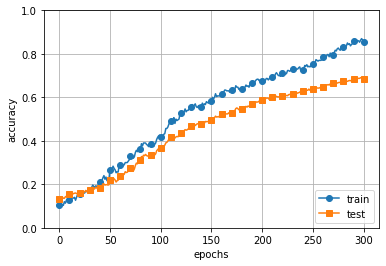

In [11]:
# 드롭아웃 사용 유무와 비울 설정
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.15

# 7층 신경망
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.grid()
plt.show()

### 하이퍼파라미터의 최적화

- 하이퍼파라미터의 최적값를 검증할 데이터가 필요한데, test 데이터를 이용하면 이에 과적합(오버피팅)되어 버리므로 별도의 데이터를 필요로 한다.
- 이러한 검증데이터(validation data)가 없을 경우, train 데이터의 20%정도를 별도로 분리해 이용할 수 있다.

In [12]:
# MNIST 데이터 불러오기
# 디폴트 설정으로 flatten=True, one_hot_label=False이다.
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]
    return x, t

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)  # 데이터셋의 편향을 없애기 위해 한번 뒤섞는다.
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [13]:
# Numpy의 permutaion 기능
np.random.permutation(10)

array([4, 7, 6, 2, 3, 1, 0, 8, 5, 9])

#### 하이퍼파라미터 최적화 방법
- 그리드 서치(grid search)같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져 있다.
- 예를들면, 0.001~1000과 같이 10의 거듭제곱으로(혹은 로그 스케일로) 하이퍼파라미터의 범위를 지정하고, 그 안에서 무작위로 샘플링해 정확도를 평가한다.
- 하이퍼파라미터의 최적화는 시간이 오래걸리므로 학습을 위한 에폭(epoch)을 작게하고, 가능성 없는 구간은 빨리 포기하는 것이 좋다.
- "베이즈 최적화(Bayesian optimization)"와 같은 세련된 방법도 있으니 아래 논문 참조할 것
- https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf

In [14]:
# 실행함수
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()
    return trainer.test_acc_list, trainer.train_acc_list

val acc:0.13675 | lr:5.846977806375344e-05, weight decay:3.447614696195861e-08
val acc:0.5086666666666667 | lr:0.00043150068731908346, weight decay:1.4344761620762815e-08
val acc:0.9133333333333333 | lr:0.003815665236810212, weight decay:2.8656023868225347e-08
val acc:0.9191666666666667 | lr:0.005116628973393738, weight decay:2.5923076094084346e-07
val acc:0.30191666666666667 | lr:0.0001906990930627088, weight decay:1.531334473873819e-07
val acc:0.15141666666666667 | lr:3.4718052752956356e-05, weight decay:3.0851795332813686e-05
val acc:0.13075 | lr:2.9528920896195658e-06, weight decay:9.863131205912355e-06
val acc:0.1145 | lr:1.1584928055753366e-06, weight decay:1.239949331006129e-08
val acc:0.13208333333333333 | lr:1.934210529855958e-05, weight decay:4.858146747211146e-05
val acc:0.14425 | lr:5.854825319559993e-06, weight decay:8.592755859316445e-08
val acc:0.1085 | lr:2.2850002963118614e-06, weight decay:1.1618499861206832e-05
val acc:0.7231666666666666 | lr:0.000774511630006029, we

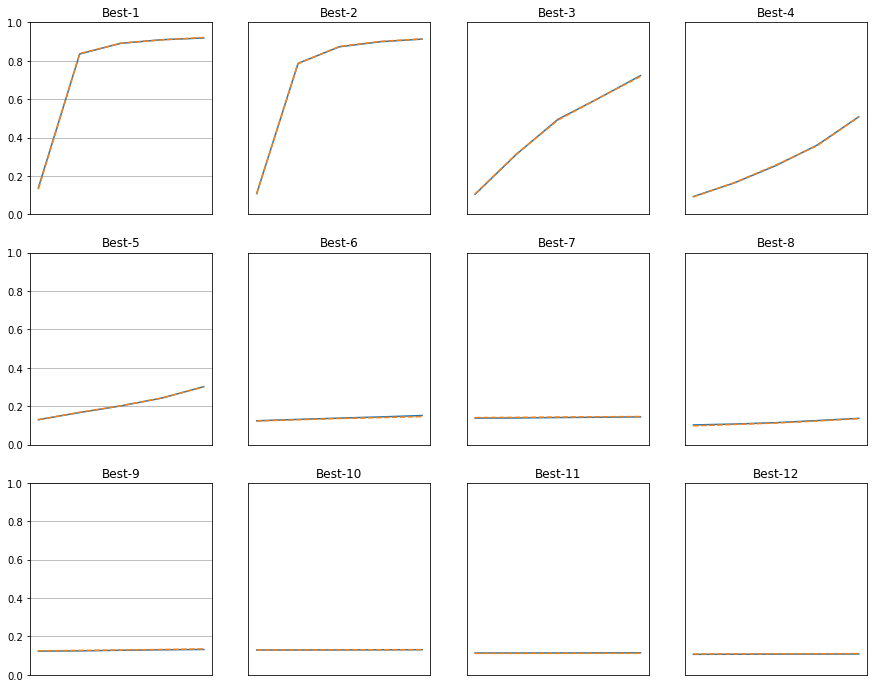

In [15]:
# 하이퍼파라미터 무작위 탐색
optimization_trial = 12  # 몇 번 무작위 추출할 것인지 설정
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay, epocs=5)  # epoch 수를 작게 설정
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 12
col_num = 4
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0
plt.figure(figsize=(15,12))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)
    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 4: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list, label="")
    plt.plot(x, results_train[key], "--")
    plt.grid()
    i += 1
    if i >= graph_draw_num: break
plt.show()